In [29]:
# -*- coding: utf-8 -*-
"""fetosense_cnn_multiclass.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1WIrJq3K717Rl5RP3ThiQbWKgCsmOawY5
"""

# Import necessary libraries for data processing, machine learning, and visualization
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from sklearn import utils
from tensorflow.keras import Sequential
from tensorflow.python.framework import ops
import tensorflow.keras.metrics as metrics
from keras.regularizers import l2
import keras
from numpy import mean
from numpy import std
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.utils.class_weight import compute_class_weight

# Custom utilities would go here, assuming they are in your environment
# from cnn_utils import *
# from test_utils import summary, comparator

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import imblearn
from imblearn.over_sampling import SMOTE  # For handling class imbalance
from sklearn.model_selection import StratifiedKFold  # For cross-validation
import sklearn.metrics as met
from numpy import sqrt
from numpy import argmax
from numpy import *

np.random.seed(1)  # Set random seed for reproducibility
from io import StringIO



In [30]:
# NEW IMPORTS for visualization and evaluation
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

# Create a directory to save plots
os.makedirs('./plots', exist_ok=True)

def generate_performance_visuals(model, history, X_test, Y_test_one_hot, le):
    """
    Generates and saves performance visualizations for the model.

    Args:
        model: The trained Keras model.
        history: The history object from model.fit().
        X_test (np.array): The test features.
        Y_test_one_hot (np.array): The test labels (one-hot encoded).
        le (LabelEncoder): The fitted LabelEncoder to get class names.
    """
    print("\n--- Generating Performance Visualizations ---")

    # 1. Plot Training History (Accuracy and Loss)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper left')

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper left')

    plt.tight_layout()
    history_plot_path = './plots/training_history.png'
    plt.savefig(history_plot_path)
    print(f"✅ Training history plot saved to: {history_plot_path}")
    plt.show()


    # 2. Generate Predictions and Classification Report
    Y_pred_probs = model.predict(X_test)
    Y_pred_int = np.argmax(Y_pred_probs, axis=1)
    Y_test_int = np.argmax(Y_test_one_hot, axis=1)
    class_names = le.classes_

    print("\nClassification Report:")
    report = classification_report(Y_test_int, Y_pred_int, target_names=class_names)
    print(report)

    # Save report to a text file
    report_path = './plots/classification_report.txt'
    with open(report_path, 'w') as f:
        f.write(report)
    print(f"✅ Classification report saved to: {report_path}")

    # 3. Generate and Plot Confusion Matrix
    cm = confusion_matrix(Y_test_int, Y_pred_int)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')

    cm_plot_path = './plots/confusion_matrix.png'
    plt.savefig(cm_plot_path)
    print(f"✅ Confusion matrix saved to: {cm_plot_path}")
    plt.show()

In [31]:


# Function to normalize each row of a matrix using StandardScaler
def normalize_matrix(x):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    x[x == 0.0] = np.nan
    x_new = scaler.fit_transform(x)
    where_are_NaNs = np.isnan(x_new)
    x_new[where_are_NaNs] = 0
    np.savetxt('sample_carenx.csv', x_new, delimiter=",")
    return x_new

# Function to load and preprocess the dataset
def load_dataset(trim_factor=1200, num_classes=4): # CHANGED: Added num_classes parameter
    """
    Loads the dataset, pads/trims signals, normalizes, and prepares labels
    for multi-class classification using one-hot encoding.
    """
    data = pd.read_excel('./data/fhr_data.xlsx', sheet_name='FHR_Lable_2', usecols='B:C')
    X_temp = np.array(data['BpmEntries'])
    Y_temp = np.array(data['Interpretation'])

    # Convert string labels to integer labels (0, 1, 2, 3)
    # KEEP THE LABEL ENCODER
    le = preprocessing.LabelEncoder()
    Y_train_int = le.fit_transform(Y_temp)
    print("The order of your labels is:")
    for i, label in enumerate(le.classes_):
        print(f"Index {i}: {label}")

    num_classes = len(le.classes_)
    print(f"Number of classes: {num_classes}")

    # CHANGED: Convert integer labels to one-hot encoded vectors
    # e.g., 2 -> [0, 0, 1, 0]
    Y_train = tf.keras.utils.to_categorical(Y_train_int, num_classes=num_classes)

    X_train = np.zeros((X_temp.shape[0], 1201))
    for i in range(X_temp.shape[0]):
        str_data = X_temp[i].lstrip("[").rstrip("]")
        signal = np.genfromtxt(StringIO(str_data), delimiter=",")
        X_train[i, 0:signal.shape[0]] = signal

    X_train = X_train[:, 0:1200]
    X_train_tran = np.transpose(X_train)
    X_train_tran = normalize_matrix(X_train_tran)
    X_train = np.transpose(X_train_tran)
    

    new_X_train = tf.expand_dims(X_train, 2)
    # Y_train is already in the correct shape after to_categorical
    new_X_train = tf.reshape(new_X_train, [new_X_train.shape[0], 1200, 1])

    print("Shape of feature data (X):", new_X_train.shape)
    print("Shape of label data (Y):", Y_train.shape)
    return new_X_train.numpy(), Y_train, le


In [32]:

# Function to build the CNN model
def convolutional_model_new2(n_timesteps, n_features, n_param, num_classes=4): # CHANGED: Added num_classes parameter
    """
    Builds a 1D CNN model for multi-class classification.
    """
    tf.keras.backend.clear_session()
    initializer = tf.keras.initializers.HeNormal()

    model = Sequential()
    model.add(tfl.Conv1D(filters=16, kernel_size=n_param, strides=1, activation='relu',
                         input_shape=(n_timesteps, n_features), kernel_initializer=initializer))
    model.add(tfl.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=1))
    model.add(tfl.Flatten())
    model.add(tfl.Dense(num_classes, activation='relu'))
    model.add(tfl.Dropout(0.15)) # Add this line. 0.15 means 15% of neurons are dropped out.

    # CHANGED: The output layer now has 4 neurons (one for each class)
    # and uses 'softmax' activation for multi-class probability distribution.
    model.add(tfl.Dense(num_classes, activation='softmax'))

    return model


In [33]:

# Function to train and evaluate the model using cross-validation and SMOTE
def evaluate_model(trainX, trainY, r, n_param, le):
    """
    Performs 10-fold stratified cross-validation for a multi-class problem.
    """
    verbose, epochs, batch_size = 1, 100, 64
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    # trainY.shape[1] will give the number of classes (e.g., 4)
    num_classes = trainY.shape[1]

    CNN_model = convolutional_model_new2(n_timesteps, n_features, n_param, num_classes)

    initial_learning_rate = 0.0001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

    # CHANGED: Loss function is now 'categorical_crossentropy'
    # CHANGED: Metrics are simplified for multi-class; removed binary-specific ones.
    CNN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                      loss='categorical_crossentropy',
                      metrics=['accuracy', metrics.AUC(), metrics.Precision(), metrics.Recall()])

    # We need integer labels for StratifiedKFold, so we convert one-hot back to integers
    trainY_integers = np.argmax(trainY, axis=1)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)

    # CHANGED: Removed binary-specific metric lists (se, sp, G_mean)
    acc_list, pre_list, recall_list, loss_list, auc_list = [], [], [], [], []

    for i, (train_idx, val_idx) in enumerate(kfold.split(trainX, trainY_integers)):
        oversample = SMOTE()
        # We use the original trainX and trainY (one-hot) for training
        trainX_fold, trainY_fold = trainX[train_idx], trainY[train_idx]
        valX_fold, valY_fold = trainX[val_idx], trainY[val_idx]

        # Reshape for SMOTE
        trainX_reshape = tf.reshape(trainX_fold, [trainX_fold.shape[0], n_timesteps * n_features])
        # SMOTE works with integer labels
        trainY_fold_integers = np.argmax(trainY_fold, axis=1)

        X_train_resampled, Y_train_resampled_int = oversample.fit_resample(trainX_reshape, trainY_fold_integers)

        # Convert resampled labels back to one-hot for training
        Y_train_resampled = tf.keras.utils.to_categorical(Y_train_resampled_int, num_classes=num_classes)
        X_train_resampled = tf.reshape(X_train_resampled, [X_train_resampled.shape[0], n_timesteps, n_features])
        class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(trainY_integers), y=trainY_integers)
        class_weights = dict(enumerate(class_weights_array))
        print("Calculated class weights:", class_weights)
        
        history = CNN_model.fit(X_train_resampled, Y_train_resampled, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=0)

        # Train the model
        history = CNN_model.fit(
        X_train_resampled, Y_train_resampled,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=0,
        class_weight=class_weights,
        validation_data=(valX_fold, valY_fold) # Use test set as validation data for history plot
    )
        # Plotting remains the same
        # ... (code for plotting loss and accuracy is fine) ...

        # Evaluate model on the validation fold
        # CHANGED: Simplified the returned metrics
        (loss, Acc, auc, prec, recall) = CNN_model.evaluate(valX_fold, valY_fold, verbose=0)

        acc_list.append(Acc)
        pre_list.append(prec)
        recall_list.append(recall) # Recall is equivalent to Sensitivity
        loss_list.append(loss)
        auc_list.append(auc)

        #generate_performance_visuals(CNN_model, history, valX_fold, valY_fold, le)

    # CHANGED: Removed ROC curve plotting as it's complex for multi-class
    # CHANGED: Return the relevant averaged metrics
    return mean(loss_list), mean(acc_list), mean(pre_list), mean(recall_list), mean(auc_list), CNN_model, history


In [34]:


# Function to run the full experiment
def run_experiment(params, repeats=16):
    trainX, trainy, le = load_dataset(trim_factor=1200, num_classes=4)
    # 2. Split data into training (80%) and testing (20%) sets
    # Use stratify to ensure class distribution is the same in train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(
        trainX, trainy, test_size=0.20, random_state=42, stratify=trainy
    )
    # CHANGED: Updated lists to match new metrics
    all_loss, all_Acc, all_pre, all_recall, all_auc = [], [], [], [], []

    for p in params:
        # CHANGED: Updated lists for each parameter run
        print(f"\n--- Running experiments for parameter (kernel_size) = {p} ---")
        loss_score, acc_score, pre_score, recall_score, auc_score = [], [], [], [], []
        for r in range(repeats):
            # CHANGED: Updated the function call to match new return values
            loss, Acc, pre, recall, auc, CNN_model, history = evaluate_model(trainX, trainy, r, p,le)
            Acc *= 100.0
            pre *= 100.0
            recall *= 100.0 # This is sensitivity
            auc *= 100.0

            print(f"\n---epeats ({repeats}) = {r+1} ---")
            print(f'>p={p} #{r+1}: loss {loss:.4f}')
            print(f' Accuracy {Acc:.2f}%')
            print(f' Precision {pre:.2f}%')
            print(f' Recall (Sen.) {recall:.2f}%') # Recall is the same as sensitivity in this context
            print(f' AUC {auc:.2f}%')

            loss_score.append(loss)
            acc_score.append(Acc)
            pre_score.append(pre)
            recall_score.append(recall)
            auc_score.append(auc)
            print('---------------------')

        all_loss.append(loss_score)
        all_Acc.append(acc_score)
        all_pre.append(pre_score)
        all_recall.append(recall_score)
        all_auc.append(auc_score)
        
        generate_performance_visuals(CNN_model, history, X_test, Y_test, le)

    # The summarize_results function would need to be updated to handle these new metrics.
    # A simplified version could just print the means and standard deviations.
    print("\n--- Experiment Summary ---")
    for i, p in enumerate(params):
        print(f"\nParameter (kernel_size) = {p}")
        print(f"  Avg Loss:      {mean(all_loss[i]):.4f} (+/- {std(all_loss[i]):.4f})")
        print(f"  Avg Accuracy:  {mean(all_Acc[i]):.2f}% (+/- {std(all_Acc[i]):.2f})")
        print(f"  Avg Precision: {mean(all_pre[i]):.2f}% (+/- {std(all_pre[i]):.2f})")
        print(f"  Avg Recall:    {mean(all_recall[i]):.2f}% (+/- {std(all_recall[i]):.2f})")
        print(f"  Avg AUC:       {mean(all_auc[i]):.2f}% (+/- {std(all_auc[i]):.2f})")

The order of your labels is:
Index 0: Borderline-reactive
Index 1: Moderately-reactive
Index 2: Non-reactive
Index 3: Reactive
Number of classes: 4
Shape of feature data (X): (396, 1200, 1)
Shape of label data (Y): (396, 4)

--- Running experiments for parameter (kernel_size) = 2 ---
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}


/Users/avinashjoshi/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calc

/Users/avinashjoshi/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calc

/Users/avinashjoshi/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calc

/Users/avinashjoshi/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calc

/Users/avinashjoshi/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calculated class weights: {0: np.float64(1.434782608695652), 1: np.float64(4.304347826086956), 2: np.float64(3.8076923076923075), 3: np.float64(0.35611510791366907)}
Calc

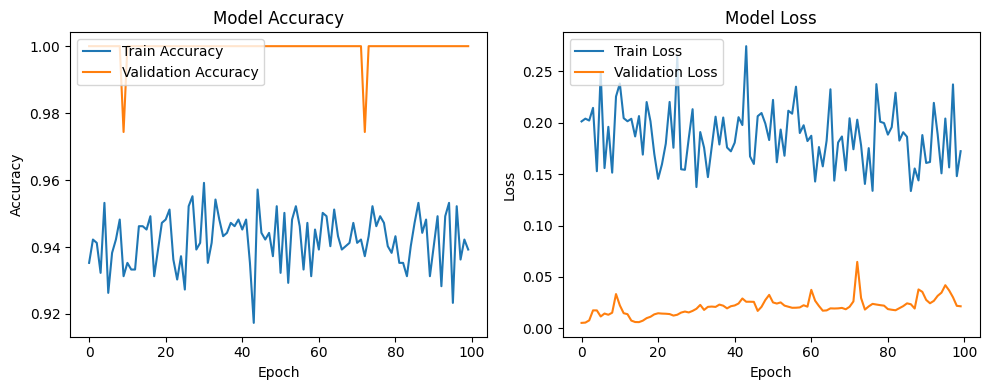

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/stepWARNING:tensorflow:5 out of the last 25 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x15b99b280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Classification Report:
                     precision    recall  f1-score   support

Borderline-reactive       1.00      1.00      1.00        14
Moderately-reactive       1.00      1.00      1.00        

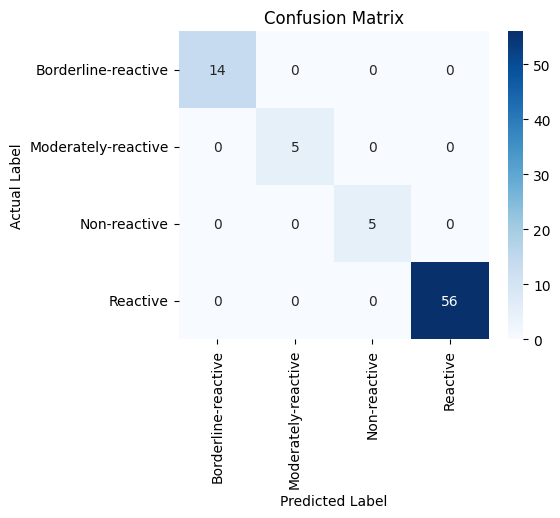


--- Experiment Summary ---

Parameter (kernel_size) = 2
  Avg Loss:      0.6217 (+/- 0.1198)
  Avg Accuracy:  88.22% (+/- 2.78)
  Avg Precision: 88.71% (+/- 2.87)
  Avg Recall:    87.87% (+/- 3.01)
  Avg AUC:       95.32% (+/- 1.23)


In [35]:

# List of kernel sizes to test
n_params = [2]  # kernel size
run_experiment(n_params, repeats=5) # You can reduce repeats for a quicker test, e.g., repeats=2